https://github.com/christopherjenness/NBA-prediction
https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py

In [1]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,keras,tensorflow -g

Using TensorFlow backend.


CPython 3.5.3
IPython 5.1.0

numpy 1.11.3
pandas 0.19.2
keras 1.2.0
tensorflow 0.10.0rc0

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.4.0-72-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 72c5182d31686b9c85995ce2b433353f418c2b9d


In [2]:
import pandas as pd

df = pd.read_pickle('./2016_scores.pkl')

In [3]:
df['difference'] = df['home_score'] - df['away_score']
df.head()

,away_score,away_team,home_score,home_team,difference
0,5,Toronto Blue Jays,3,Tampa Bay Rays,-2
1,1,St. Louis Cardinals,4,Pittsburgh Pirates,3
2,3,New York Mets,4,Kansas City Royals,1
3,2,Seattle Mariners,3,Texas Rangers,1
4,5,Toronto Blue Jays,3,Tampa Bay Rays,-2


In [4]:
list_of_teams = list(df['away_team'].unique()) 

In [5]:
list_of_teams = df['away_team'].unique()
n_teams = len(list_of_teams)

teamid2idx = {o:i for i,o in enumerate(list_of_teams)}
idx2teamid = {teamid2idx[key]:key for key in teamid2idx.keys()}

In [6]:
df.away_team = df.away_team.apply(lambda x: teamid2idx[x])
df.home_team = df.home_team.apply(lambda x: teamid2idx[x])

In [7]:
import numpy as np

msk = np.random.rand(len(df)) < 0.8
trn = df[msk]
val = df[~msk]

In [8]:
from keras.layers import Input, Embedding, merge
from keras.layers.core import Flatten
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam

In [9]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [10]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [11]:
n_factors = 2

away_in = Input(shape=(1,), dtype='int64', name='away_in')
home_in = Input(shape=(1,), dtype='int64', name='home_in')

embedding_layer = Embedding(n_teams, n_factors, input_length=1, W_regularizer=l2(1e-4))

#away_in, a = embedding_input('away_in', n_teams, n_factors, 1e-4)
#home_in, h = embedding_input('home_in', n_teams, n_factors, 1e-4)

a = embedding_layer(away_in)
h = embedding_layer(home_in)

ab = create_bias(away_in, n_teams)
hb = create_bias(home_in, n_teams)

x = merge([a, h], mode='dot')
x = Flatten()(x)
x = merge([x, ab], mode='sum')
x = merge([x, hb], mode='sum')
model = Model([away_in, home_in], x)
model.compile(Adam(0.001), loss='mse')

In [12]:
model.fit([trn.away_team, trn.home_team], trn.difference, batch_size=64, nb_epoch=1, 
          validation_data=([val.away_team, val.home_team], val.difference))

Train on 1959 samples, validate on 504 samples
Epoch 1/1
1959/1959 [==============================] - 0s - loss: 18.3939 - val_loss: 19.2317


In [13]:
model.optimizer.lr=0.01
model.fit([trn.away_team, trn.home_team], trn.difference, batch_size=64, nb_epoch=6, 
          validation_data=([val.away_team, val.home_team], val.difference))

Train on 1959 samples, validate on 504 samples
Epoch 1/6
1959/1959 [==============================] - 0s - loss: 18.3673 - val_loss: 19.2271
Epoch 2/6
1959/1959 [==============================] - 0s - loss: 18.3447 - val_loss: 19.2208: 18.42
Epoch 3/6
1959/1959 [==============================] - 0s - loss: 18.3232 - val_loss: 19.2184
Epoch 4/6
1959/1959 [==============================] - 0s - loss: 18.3002 - val_loss: 19.2128
Epoch 5/6
1959/1959 [==============================] - 0s - loss: 18.2789 - val_loss: 19.2074
Epoch 6/6
1959/1959 [==============================] - 0s - loss: 18.2568 - val_loss: 19.2036


In [14]:
model.optimizer.lr=0.001
model.fit([trn.away_team, trn.home_team], trn.difference, batch_size=64, nb_epoch=5, 
          validation_data=([val.away_team, val.home_team], val.difference))

Train on 1959 samples, validate on 504 samples
Epoch 1/5
1959/1959 [==============================] - 0s - loss: 18.2359 - val_loss: 19.2007
Epoch 2/5
1959/1959 [==============================] - 0s - loss: 18.2140 - val_loss: 19.1982
Epoch 3/5
1959/1959 [==============================] - 0s - loss: 18.1922 - val_loss: 19.1933
Epoch 4/5
1959/1959 [==============================] - 0s - loss: 18.1710 - val_loss: 19.1917
Epoch 5/5
1959/1959 [==============================] - 0s - loss: 18.1485 - val_loss: 19.1912


https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson4.ipynb

In [15]:
get_away_bias = Model(away_in, ab)
away_bias = get_away_bias.predict(df.away_team.unique())
away_rating = [(b[0], idx2teamid[i]) for i,b in zip(df.away_team.unique(),away_bias)]              
                
sorted(away_rating,  key=lambda x: x[0], reverse=True)[:15]

[(0.19213127, 'Philadelphia Phillies'),
 (0.13538371, 'Colorado Rockies'),
 (0.1154874, 'Cincinnati Reds'),
 (0.10293819, 'San Diego Padres'),
 (0.091762304, 'New York Yankees'),
 (0.086704448, 'Atlanta Braves'),
 (0.086652882, 'Chicago White Sox'),
 (0.073435932, 'Milwaukee Brewers'),
 (0.066562518, "Arizona D'Backs"),
 (0.054421984, 'Baltimore Orioles'),
 (0.050462101, 'Kansas City Royals'),
 (0.041441962, 'LA Angels of Anaheim'),
 (0.033019256, 'Houston Astros'),
 (0.021627087, 'Tampa Bay Rays'),
 (0.01519491, 'Miami Marlins')]

In [16]:
sorted(away_rating,  key=lambda x: x[0])[:15]

[(-0.16621463, 'Washington Nationals'),
 (-0.1011001, 'Toronto Blue Jays'),
 (-0.094313346, 'Boston Red Sox'),
 (-0.082905471, 'St. Louis Cardinals'),
 (-0.071792163, 'Chicago Cubs'),
 (-0.07038597, 'New York Mets'),
 (-0.054257698, 'San Francisco Giants'),
 (-0.050478533, 'Texas Rangers'),
 (-0.028976118, 'Seattle Mariners'),
 (-0.028675666, 'Pittsburgh Pirates'),
 (-0.010899131, 'Oakland Athletics'),
 (0.0073902896, 'Cleveland Indians'),
 (0.0084861945, 'Detroit Tigers'),
 (0.014417341, 'Minnesota Twins'),
 (0.014768536, 'Los Angeles Dodgers')]

In [17]:
mse = []
for i in range(100):
    shuff_scores = df.difference.values.copy()
    np.random.shuffle(shuff_scores)
    t_mse = np.mean((df.difference-shuff_scores)**2)
    mse.append(t_mse) 

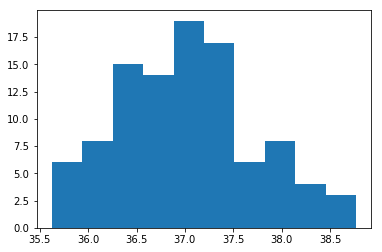

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(mse);

In [23]:
teams[1].away_team

0

In [31]:
predictions = model.predict([df.away_team.values, df.home_team.values])
t_mse = (df.difference-np.squeeze(predictions))**2
print(np.mean(t_mse))

18.3493827748383


In [35]:
predictions = model.predict([df.away_team.values, df.home_team.values])
np.random.shuffle(predictions)
t_mse = (df.difference-np.squeeze(predictions))**2
print(np.mean(t_mse))

18.589783174166605


In [37]:
predictions[0:10]

array([[-0.06541088],
       [ 0.15904462],
       [ 0.03773554],
       [-0.12947126],
       [-0.05763809],
       [-0.09660609],
       [ 0.19942555],
       [ 0.28710777],
       [ 0.07351479],
       [-0.0760739 ]], dtype=float32)